<a href="https://colab.research.google.com/github/Skander28/Models/blob/main/valence%2Bclustring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
tweets_ids = pd.read_csv('/content/drive/MyDrive/maghrebi/dialect_dataset.csv')
     

# Read the given dataset which contain the Ids and the labels
df_clean = pd.read_csv('/content/drive/MyDrive/maghrebi/messages.csv',
                 lineterminator='\n')

column_names = ['id', 'tweets']  # list of column names

df_clean.columns = column_names

tweets_dataset = pd.merge(tweets_ids, df_clean, on='id', how='inner')
tweets_dataset.head()

,id,dialect,tweets
0,1175358310087892992,IQ,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .
1,1175416117793349632,IQ,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...
2,1175450108898565888,IQ,@KanaanRema مبين من كلامه خليجي
3,1175471073770573824,IQ,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐
4,1175496913145217024,IQ,@hmo2406 وين هل الغيبه اخ محمد 🌸🌺


In [4]:
filtered_df = tweets_dataset[tweets_dataset['dialect'].isin(['TN','DZ','MA','LY'])]
filtered_df.head()

,id,dialect,tweets
15497,1009754958479151232,LY,@toha_Altomy @gy_yah قليلين ادب ومنافقين. لو ا...
15498,1009794751548313600,LY,@AlmFaisal 😂😂 الليبيين متقلبين!!!\nبس بالنسبة ...
15499,1019989115490787200,LY,@smsm071990 @ALMOGRBE كل 20 تانيه شاب ليبي بير...
15500,1035479791758135168,LY,@AboryPro @lyranoo85 رانيا عقليتك متخلفة. اولا...
15501,1035481122921164800,LY,@lyranoo85 شكلك متعقدة علشان الراجل لي تحبيه ا...


In [5]:
import string

arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

filtered_df['tweets'] = filtered_df['tweets'].apply(remove_punctuations)

<ipython-input-5-a956f0d90669>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['tweets'] = filtered_df['tweets'].apply(remove_punctuations)


In [6]:
import re
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
  
filtered_df['tweets'] = filtered_df['tweets'].apply(remove_emoji)

<ipython-input-6-d2b9976cc34a>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['tweets'] = filtered_df['tweets'].apply(remove_emoji)


In [7]:
def remove_non_arabic(text):
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = re.sub('([@A-Za-z0-9_ـــــــــــــ]+)|[^\w\s]|#|http\S+',' ',text)
    text = re.sub(r'\\u[A-Za-z0-9]\\+',' ',text)         #'\\u003c\\1'  error
    return text

filtered_df['tweets'] = filtered_df['tweets'].apply(remove_non_arabic)

<ipython-input-7-4d35f05c99fa>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['tweets'] = filtered_df['tweets'].apply(remove_non_arabic)


In [8]:
import re
import nltk

In [9]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=stopwords.words('arabic')
     
filtered_df['tweets'] = filtered_df['tweets'].apply(lambda x:" ".join(x for x in x.split() if x not in stop))
filtered_df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-9-a90dd1639aeb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['tweets'] = filtered_df['tweets'].apply(lambda x:" ".join(x for x in x.split() if x not in stop))


,id,dialect,tweets
15497,1009754958479151232,LY,قليلين ادب ومنافقين اختهم او قريبتهم تتعاكس تق...
15498,1009794751548313600,LY,الليبيين متقلبين بالنسبة ليا انا ميليشياوي زما...
15499,1019989115490787200,LY,تانيه شاب ليبي بيرتاح لبنت مختلفة ويلاحظ انها ...
15500,1035479791758135168,LY,رانيا عقليتك متخلفة اولا الانسان يلي يحتاج اهل...
15501,1035481122921164800,LY,شكلك متعقدة علشان الراجل تحبيه ازوج بنت يتيمة ...


In [10]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
filtered_df['tweets'] = filtered_df['tweets'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word, pos=wordnet.VERB) for word in x.split()]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
<ipython-input-10-99d7a08d6300>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['tweets'] = filtered_df['tweets'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word, pos=wordnet.VERB) for word in x.split()]))


In [11]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(filtered_df.drop('dialect', axis=1), filtered_df['dialect'])
filtered_df = pd.concat([X_resampled, y_resampled], axis=1)

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# define the Arabic Vader sentiment analyzer
arabic_analyzer = SentimentIntensityAnalyzer()

# define a function to calculate the valence score and extract the highest valence words for an Arabic sentence
def process_arabic_sentence(sentence):
    valence_scores = arabic_analyzer.polarity_scores(sentence)
    highest_words = []
    max_valence_score = max(valence_scores.values())
    for word in sentence.split():
        word_valence_scores = arabic_analyzer.polarity_scores(word)
        if max(word_valence_scores.values()) == max_valence_score:
            highest_words.append(word)
    return valence_scores['compound'], set(highest_words)

# group the filtered dataframe by dialect and apply the process_arabic_sentence function to each sentence in each group
grouped = filtered_df.groupby('dialect')['tweets'].apply(lambda x: x.apply(process_arabic_sentence).tolist())

# create a new dataframe with the highest valence words for each dialect
#results = pd.DataFrame({'dialect': grouped.index, 'highest_valence_words': grouped.values})



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [16]:
# define a function to extract the highest valence words for an Arabic sentence
def extract_highest_words(sentence):
    _, highest_words = process_arabic_sentence(sentence)
    return list(highest_words)

# apply the extract_highest_words function to each sentence in the dataframe and group the resulting words by dialect
grouped = filtered_df.groupby('dialect')['tweets'].apply(lambda x: x.apply(extract_highest_words).sum())

# create a new dataframe with the results
df = pd.DataFrame(grouped)

# print the dataframe
print(df)


                                                    tweets
dialect                                                   
DZ       [الزين, يحفظك, يمه, ربي, ينعاد, رب, عليكم, بال...
LY       [عليهم, قريبتهم, المرأة, فعلهم, او, اختهم, حقو...
MA       [احلى, شي, انا, عارفاه, صوتي, روحي, يحرمني, قل...
TN       [يوقف, وشوف, معاك, ناسبكريقالوا, مثلشعبيتونسي,...


In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering

# vectorize the Arabic words using TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['tweets'].apply(lambda x: ' '.join(x)))

# perform hierarchical clustering with Ward linkage
model = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=0.5)
model.fit(X.toarray())

# add the cluster labels to the dataframe
df['cluster'] = model.labels_

print(df)

                                                    tweets  cluster
dialect                                                            
DZ       [الزين, يحفظك, يمه, ربي, ينعاد, رب, عليكم, بال...        2
LY       [عليهم, قريبتهم, المرأة, فعلهم, او, اختهم, حقو...        3
MA       [احلى, شي, انا, عارفاه, صوتي, روحي, يحرمني, قل...        1
TN       [يوقف, وشوف, معاك, ناسبكريقالوا, مثلشعبيتونسي,...        0


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering

# vectorize the Arabic words using TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['tweets'].apply(lambda x: ' '.join(x)))

# perform hierarchical clustering with Ward linkage
model = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=0.5)
model.fit(X.toarray())

# create a dictionary that maps cluster labels to dialect names
cluster_to_dialect = dict(enumerate(df.index))

# replace the cluster labels with their corresponding dialect names in the dataframe
df['cluster'] = [cluster_to_dialect[label] for label in model.labels_]

print(df)

                                                    tweets cluster
dialect                                                           
DZ       [الزين, يحفظك, يمه, ربي, ينعاد, رب, عليكم, بال...      MA
LY       [عليهم, قريبتهم, المرأة, فعلهم, او, اختهم, حقو...      TN
MA       [احلى, شي, انا, عارفاه, صوتي, روحي, يحرمني, قل...      LY
TN       [يوقف, وشوف, معاك, ناسبكريقالوا, مثلشعبيتونسي,...      DZ


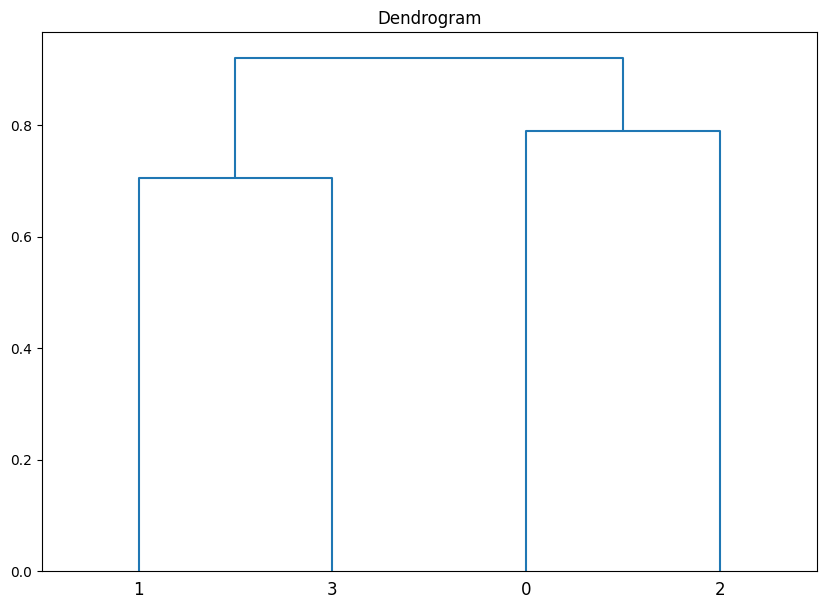

In [36]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc

# define a list of string labels that correspond to each dialect index
#labels = ['Libyian', 'Tunisian','Maroccain','Algerian']

# plot the dendrogram
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
dend = shc.dendrogram(shc.linkage(X.toarray(), method='ward'))#, labels=labels)

# show the plot
plt.show()
